<a href="https://colab.research.google.com/github/jaiminshah2023/Google_Collab/blob/main/Lit_Rev_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Forecasting Comparison:
                   Forecasting Method      MAPE        MAD           MSD  Rank
4                Quadratic Regression  0.843402  50.672595   3787.710490   1.0
5                               ARIMA  0.912440  45.158297   4664.739279   2.0
0  Single Exponential Smoothing (SES)  0.922419  46.169832   4747.295654   3.0
3                   Linear Regression  0.926971  46.451156   4790.050804   4.0
1  Double Exponential Smoothing (DES)  0.950606  47.540195   5002.872865   5.0
2                      Winters Method  1.005624  44.922084   5943.751507   6.0
6                          SEIR Model  1.459325  92.694540  12683.039684   7.0


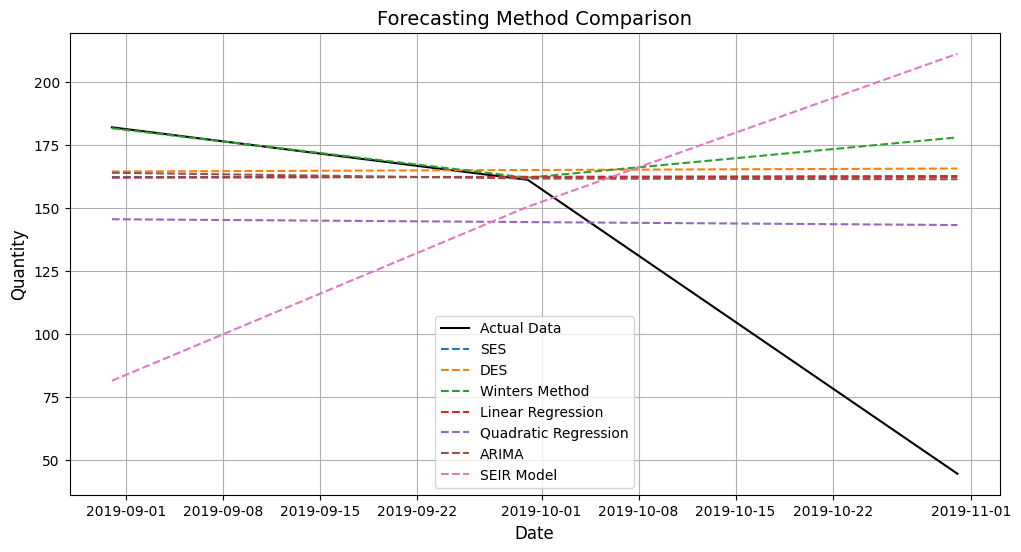

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # Suppress warnings for clean output

# SEIR Model Implementation
def SEIR_model(S, E, I, R, beta, sigma, gamma, N, days):
    results = []
    for _ in range(days):
        new_exposed = beta * S * I / N
        new_infected = sigma * E
        new_recovered = gamma * I

        S -= new_exposed
        E += new_exposed - new_infected
        I += new_infected - new_recovered
        R += new_recovered

        results.append((S, E, I, R))

    return np.array(results)

# Forecasting Methods and Error Metrics
def calculate_errors(actual, predicted, method_name):
    """Calculate MAPE, MAD, and MSD for a given forecast."""
    mape = mean_absolute_percentage_error(actual, predicted)
    mad = mean_absolute_error(actual, predicted)
    msd = mean_squared_error(actual, predicted)
    return {"Forecasting Method": method_name, "MAPE": mape, "MAD": mad, "MSD": msd}

# Data Preparation
data = {
    "datum": [
        "31-01-2014", "28-02-2014", "31-03-2014", "30-04-2014", "31-05-2014",
        "30-06-2014", "31-07-2014", "31-08-2014", "30-09-2014", "31-10-2014",
        "30-11-2014", "31-12-2014", "31-01-2015", "28-02-2015"
    ],
    "M01AB": [
        127.69, 133.32, 137.44, 113.1, 101.79, 112.07, 117.06, 134.79,
        108.78, 154.75, 138.08, 131.9, 135.91, 115.71
    ]
}

df = pd.read_csv('salesmonthly.csv')

# Convert 'datum' to datetime format
df['datum'] = pd.to_datetime(df['datum'], format='%Y-%m-%d')
df.set_index('datum', inplace=True)

# Prepare the data
data_m01ab = df['M01AB']
train = data_m01ab[:-3]  # Use all except the last 3 data points for training
test = data_m01ab[-3:]   # Use the last 3 data points for testing

# Store results in a list
results = []

# 1. Single Exponential Smoothing (SES)
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(steps=3)
results.append(calculate_errors(test, ses_forecast, "Single Exponential Smoothing (SES)"))

# 2. Double Exponential Smoothing (DES)
des_model = ExponentialSmoothing(train, trend="add").fit()
des_forecast = des_model.forecast(steps=3)
results.append(calculate_errors(test, des_forecast, "Double Exponential Smoothing (DES)"))

# 3. Winters Method (Triple Exponential Smoothing)
winters_model = ExponentialSmoothing(train, seasonal="add", trend="add", seasonal_periods=12).fit()
winters_forecast = winters_model.forecast(steps=3)
results.append(calculate_errors(test, winters_forecast, "Winters Method"))

# 4. Linear Regression
X_train = np.arange(len(train)).reshape(-1, 1)
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
linear_model = LinearRegression()
linear_model.fit(X_train, train)
linear_forecast = linear_model.predict(X_test)
results.append(calculate_errors(test, linear_forecast, "Linear Regression"))

# 5. Quadratic Regression
poly = PolynomialFeatures(degree=2)
X_train_quad = poly.fit_transform(X_train)
X_test_quad = poly.transform(X_test)
quad_model = LinearRegression()
quad_model.fit(X_train_quad, train)
quad_forecast = quad_model.predict(X_test_quad)
results.append(calculate_errors(test, quad_forecast, "Quadratic Regression"))

# 6. ARIMA
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=3)
results.append(calculate_errors(test, arima_forecast, "ARIMA"))

# 7. SEIR Model (Forecasting infectious cases)
# Assuming SEIR forecasted infectious cases (I) are proportional to demand
# Simulate the SEIR model over 3 steps as in previous implementation
N = 1000000  # Total population
S, E, I, R = 999000, 1000, 0, 0  # Initial compartment values
beta, sigma, gamma = 0.3, 0.1, 0.05  # Transmission, incubation, and recovery rates
seir_results = SEIR_model(S, E, I, R, beta, sigma, gamma, N, len(test))
seir_forecast = seir_results[-len(test):, 2]  # Infectious population (I)
# Scale SEIR results to match demand scale
seir_forecast_scaled = seir_forecast / max(seir_forecast) * max(train)
results.append(calculate_errors(test, seir_forecast_scaled, "SEIR Model"))

# Convert results to DataFrame and rank methods based on MAPE
results_df = pd.DataFrame(results)
results_df["Rank"] = results_df["MAPE"].rank(method="min")
results_df.sort_values(by="Rank", inplace=True)

# Display results in tabular format
print("\nForecasting Comparison:")
print(results_df)

# Plot the forecasting results for comparison
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Data", color="black")
plt.plot(test.index, ses_forecast, label="SES", linestyle="--")
plt.plot(test.index, des_forecast, label="DES", linestyle="--")
plt.plot(test.index, winters_forecast, label="Winters Method", linestyle="--")
plt.plot(test.index, linear_forecast, label="Linear Regression", linestyle="--")
plt.plot(test.index, quad_forecast, label="Quadratic Regression", linestyle="--")
plt.plot(test.index, arima_forecast, label="ARIMA", linestyle="--")
plt.plot(test.index, seir_forecast_scaled, label="SEIR Model", linestyle="--")

plt.title("Forecasting Method Comparison", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Quantity", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(ses_model.params['smoothing_level'])


0.22532651694294045


 **A Proposed Model for Drug Demand Forecasting
and Ordering Inventory System for Dengue
Endemic**

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # Suppress warnings for clean output

class SEIRModel:
    def __init__(self, S, E, I, R, beta, sigma, gamma, N, days):
        self.S, self.E, self.I, self.R = S, E, I, R
        self.beta, self.sigma, self.gamma, self.N, self.days = beta, sigma, gamma, N, days

    def run(self):
        results = []
        for _ in range(self.days):
            new_exposed = self.beta * self.S * self.I / self.N
            new_infected = self.sigma * self.E
            new_recovered = self.gamma * self.I

            self.S -= new_exposed
            self.E += new_exposed - new_infected
            self.I += new_infected - new_recovered
            self.R += new_recovered

            results.append((self.S, self.E, self.I, self.R))

        return np.array(results)

class Forecasting:
    def __init__(self, data):
        self.data = data
        self.results = {}

    def calculate_errors(self, actual, predicted, method_name):
        """Calculate MAPE, MAD, and MSD for a given forecast."""
        mape = mean_absolute_percentage_error(actual, predicted)
        mad = mean_absolute_error(actual, predicted)
        msd = mean_squared_error(actual, predicted)
        return {"Forecasting Method": method_name, "MAPE": mape, "MAD": mad, "MSD": msd}

    def apply_methods(self):
        for drug in self.data.columns:
            results = []
            train = self.data[drug][:-3]
            test = self.data[drug][-3:]

            # 1. Single Exponential Smoothing (SES)
            ses_model = SimpleExpSmoothing(train).fit()
            ses_forecast = ses_model.forecast(steps=3)
            results.append(self.calculate_errors(test, ses_forecast, "SES"))

            # 2. Double Exponential Smoothing (DES)
            des_model = ExponentialSmoothing(train, trend="add").fit()
            des_forecast = des_model.forecast(steps=3)
            results.append(self.calculate_errors(test, des_forecast, "DES"))

            # 3. Winters Method (if applicable)
            try:
                winters_model = ExponentialSmoothing(train, seasonal="add", trend="add", seasonal_periods=6).fit()
                winters_forecast = winters_model.forecast(steps=3)
                results.append(self.calculate_errors(test, winters_forecast, "Winters Method"))
            except ValueError:
                print(f"Skipping Winters Method for {drug} due to insufficient data.")

            # 4. Linear Regression
            X_train = np.arange(len(train)).reshape(-1, 1)
            X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
            linear_model = LinearRegression()
            linear_model.fit(X_train, train)
            linear_forecast = linear_model.predict(X_test)
            results.append(self.calculate_errors(test, linear_forecast, "Linear Regression"))

            # 5. Quadratic Regression
            poly = PolynomialFeatures(degree=2)
            X_train_quad = poly.fit_transform(X_train)
            X_test_quad = poly.transform(X_test)
            quad_model = LinearRegression()
            quad_model.fit(X_train_quad, train)
            quad_forecast = quad_model.predict(X_test_quad)
            results.append(self.calculate_errors(test, quad_forecast, "Quadratic Regression"))

            # 6. ARIMA
            arima_model = ARIMA(train, order=(1, 1, 1)).fit()
            arima_forecast = arima_model.forecast(steps=3)
            results.append(self.calculate_errors(test, arima_forecast, "ARIMA"))

            # 7. SEIR Model
            seir_model = SEIRModel(S=999000, E=1000, I=0, R=0, beta=0.3, sigma=0.1, gamma=0.05, N=1000000, days=len(test))
            seir_results = seir_model.run()
            seir_forecast = seir_results[-len(test):, 2]  # Infectious population (I)
            seir_forecast_scaled = seir_forecast / max(seir_forecast) * max(train)
            results.append(self.calculate_errors(test, seir_forecast_scaled, "SEIR Model"))

            # Store and rank results
            results_df = pd.DataFrame(results)
            results_df["Rank"] = results_df["MAPE"].rank(method="min")
            results_df.sort_values(by="Rank", inplace=True)
            self.results[drug] = results_df

            # Print results for each drug
            print(f"\nForecasting Comparison for {drug}:")
            print(results_df)

    def get_best_methods(self):
        return {drug: df.iloc[0]["Forecasting Method"] for drug, df in self.results.items()}

class InventoryManagement:
    def __init__(self, forecast_results):
        self.forecast_results = forecast_results

    def calculate_inventory(self, demand, order_quantity, holding_cost, ordering_cost, safety_stock):
        order_frequency = demand / order_quantity
        total_holding_cost = holding_cost * (order_quantity / 2 + safety_stock)
        total_ordering_cost = ordering_cost * order_frequency
        total_cost = total_holding_cost + total_ordering_cost
        return total_cost, order_frequency

# Load dataset
df = pd.read_csv("salesmonthly.csv")

# Convert 'datum' to datetime format and set as index
df['datum'] = pd.to_datetime(df['datum'])
df.set_index('datum', inplace=True)

# Apply forecasting methods
forecasting = Forecasting(df)
forecasting.apply_methods()
best_methods = forecasting.get_best_methods()

# Apply inventory management
inventory = InventoryManagement(best_methods)
print("\nBest Forecasting Methods per Drug:")
print(best_methods)



Forecasting Comparison for M01AB:
     Forecasting Method      MAPE        MAD           MSD  Rank
4  Quadratic Regression  0.843402  50.672595   3787.710490   1.0
5                 ARIMA  0.912440  45.158297   4664.739279   2.0
0                   SES  0.922419  46.169832   4747.295654   3.0
3     Linear Regression  0.926971  46.451156   4790.050804   4.0
1                   DES  0.950606  47.540195   5002.872865   5.0
2        Winters Method  1.014297  49.995560   5711.559980   6.0
6            SEIR Model  1.459325  92.694540  12683.039684   7.0

Forecasting Comparison for M01AE:
     Forecasting Method      MAPE        MAD           MSD  Rank
4  Quadratic Regression  0.751775  32.728357   2011.506249   1.0
0                   SES  0.825535  37.243693   2346.080423   2.0
5                 ARIMA  0.844892  38.235038   2441.322436   3.0
1                   DES  0.861370  39.522463   2521.334046   4.0
3     Linear Regression  0.861383  39.523282   2521.399362   5.0
2        Winters Met

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define date ranges for different frequencies
date_range_daily = pd.date_range(start="2019-01-01", end="2024-12-31", freq="D")
date_range_weekly = pd.date_range(start="2019-01-01", end="2024-12-31", freq="W")
date_range_monthly = pd.date_range(start="2019-01-01", end="2024-12-31", freq="M")
date_range_quarterly = pd.date_range(start="2019-01-01", end="2024-12-31", freq="Q")

# Drug names for simulation
drug_names = ["Paracetamol", "Ibuprofen", "Aspirin", "Amoxicillin", "Metformin", "Cetrizine", "Omeprazole", "Atorvastatin"]

# Sales channels and location parameters
zones = ["North", "South", "East", "West"]
regions = ["Metro", "Urban", "Suburban", "Rural"]
states = ["California", "Texas", "New York", "Florida", "Illinois"]
districts = ["District A", "District B", "District C", "District D"]

# Function to generate synthetic data
def generate_data(date_range):
    num_rows = len(date_range)
    data = {
        "datum": date_range,
        "drug_name": np.random.choice(drug_names, num_rows),
        "quantity_sold": np.random.randint(50, 500, num_rows),
        "volume_sold": np.random.randint(100, 10000, num_rows),
        "sale_price_per_unit": np.round(np.random.uniform(5, 50, num_rows), 2),
        # "total_sales": lambda df: df["quantity_sold"] * df["sale_price_per_unit"], # This line caused the error
        "demand_forecasted": np.random.randint(60, 550, num_rows),
        "stock_available": np.random.randint(10, 300, num_rows),
        "sales_online": np.random.randint(10, 150, num_rows),
        "sales_offline": np.random.randint(20, 250, num_rows),
        "sales_hospitals": np.random.randint(15, 200, num_rows),
        "sales_others": np.random.randint(5, 100, num_rows),
        "zone": np.random.choice(zones, num_rows),
        "region": np.random.choice(regions, num_rows),
        "state": np.random.choice(states, num_rows),
        "district": np.random.choice(districts, num_rows),
        "urban_rural": np.random.choice(["Urban", "Rural"], num_rows),
        "hospital_name": np.random.choice(["General Hospital", "City Medical", "Regional Care", "Health Center"], num_rows),
        "hospital_beds": np.random.randint(100, 1000, num_rows),
        "patients_admitted": np.random.randint(50, 900, num_rows),
        "order_quantity": np.random.randint(50, 400, num_rows),
        "safety_stock": np.random.randint(20, 150, num_rows),
        "seasonal_demand_factor": np.round(np.random.uniform(0.8, 1.2, num_rows), 2),
        "discounts_offered": np.round(np.random.uniform(0, 20, num_rows), 2),
        "competitor_sales": np.random.randint(30, 400, num_rows),
        "supply_chain_disruptions": np.random.choice(["None", "Low", "Medium", "High"], num_rows),
    }
    df = pd.DataFrame(data)
    # Calculate total_sales after DataFrame creation
    df["total_sales"] = df["quantity_sold"] * df["sale_price_per_unit"]  # Compute total sales column
    return df

# Generate data for different frequencies
df_daily = generate_data(date_range_daily)
df_weekly = generate_data(date_range_weekly)
df_monthly = generate_data(date_range_monthly)
df_quarterly = generate_data(date_range_quarterly)

# Save as CSV files
file_paths = {
    "daily": "pharma_daily.csv",
    "weekly": "pharma_weekly.csv",
    "monthly": "pharma_monthly.csv",
    "quarterly": "pharma_quarterly.csv",
}

df_daily.to_csv(file_paths["daily"], index=False)
df_weekly.to_csv(file_paths["weekly"], index=False)
df_monthly.to_csv(file_paths["monthly"], index=False)
df_quarterly.to_csv(file_paths["quarterly"], index=False)

# Return file paths for download
file_paths


<ipython-input-3-f885a2fe4108>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range_monthly = pd.date_range(start="2019-01-01", end="2024-12-31", freq="M")
<ipython-input-3-f885a2fe4108>:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  date_range_quarterly = pd.date_range(start="2019-01-01", end="2024-12-31", freq="Q")


{'daily': 'pharma_daily.csv',
 'weekly': 'pharma_weekly.csv',
 'monthly': 'pharma_monthly.csv',
 'quarterly': 'pharma_quarterly.csv'}